In [1]:
# === Imports ===
import pandas as pd
import numpy as np
import torch
from sentence_transformers import SentenceTransformer, util
import matplotlib.pyplot as plt

c:\Users\User\Workspace\SCAI_code\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# === Load Data ===
gold_file = '../data/gold_standard_comparison/Triples_CBM_Gold_Standard.xlsx' #data/gold_standard_comparison/Triples_CBM_Gold_Standard.xlsx
eval_file = '../data/gold_standard_comparison/Triples_GPT_for_comparison.xlsx' #data/gold_standard_comparison/Triples_GPT_for_comparison.xlsx 

df_Gold = pd.read_excel(gold_file)
df_Eval = pd.read_excel(eval_file)

# === Load Sentence-BERT Model ===
model = SentenceTransformer('all-MiniLM-L6-v2')

# === Helper Functions ===
def create_subject_object_dict(df):
    triple_dict = {}
    for _, row in df.iterrows():
        key = row['Image_number']
        subj = row['Subject'].replace('_', ' ') if pd.notna(row['Subject']) else ''
        obj = row['Object'].replace('_', ' ') if pd.notna(row['Object']) else ''
        if subj and obj:
            phrase = f"{subj} {obj}"
            triple_dict.setdefault(key, []).append(phrase)
    return triple_dict

def similarity_metrics(df_gold, df_extracted, image_key, threshold):
    gold_dict = create_subject_object_dict(df_gold)
    eval_dict = create_subject_object_dict(df_extracted)

    gold = gold_dict.get(image_key, [])
    extracted = eval_dict.get(image_key, [])
    if not gold or not extracted:
        return None, None, None, None, None

    gold_embeds = model.encode(gold, convert_to_tensor=True)
    eval_embeds = model.encode(extracted, convert_to_tensor=True)

    sims = util.cos_sim(eval_embeds, gold_embeds).cpu().numpy()
    TP, FP, FN = 0, 0, 0
    best_scores = []

    for i in range(len(extracted)):
        best_score = sims[i].max()
        # best_scores.append(best_score)
        if best_score >= threshold:
            TP += 1
            best_scores.append(best_score)  # Only count matched pairs (TP)
        else:
            FP += 1
    FN = max(0, len(gold) - TP)
    prec = TP / (TP + FP) if (TP + FP) > 0 else 0
    rec = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * prec * rec / (prec + rec) if (prec + rec) > 0 else 0

    # Average similarity calculation:
    if best_scores:  # Only if there were matches
        avg_sim = np.mean(best_scores)
    else:
        avg_sim = 0  # No matches → avg_sim = 0

    css = 0.6 * avg_sim + 0.4 * f1
    
    return css, avg_sim, prec, rec, f1

def compare_all_images(df_gold, df_eval, threshold):
    keys_gold = set(df_gold['Image_number'].unique())
    keys_eval = set(df_eval['Image_number'].unique())
    common_keys = keys_gold & keys_eval

    def natural_sort_key(k):
        return int(k.split('_')[-1])

    css_list, sim_list, prec_list, rec_list, f1_list = [], [], [], [], []

    for key in sorted(common_keys, key=natural_sort_key):
        css, avg_sim, prec, rec, f1 = similarity_metrics(df_gold, df_eval, key, threshold)
        if css is not None:
            css_list.append(css)
            sim_list.append(avg_sim)
            prec_list.append(prec)
            rec_list.append(rec)
            f1_list.append(f1)

    return {
        'CSS': np.mean(css_list),
        'Avg_Similarity': np.mean(sim_list),
        'Precision': np.mean(prec_list),
        'Recall': np.mean(rec_list),
        'F1': np.mean(f1_list)
    }

# === Threshold Sweep ===
thresholds = np.arange(0.5, 0.96, 0.05)
results = []

for th in thresholds:
    metrics = compare_all_images(df_Gold, df_Eval, threshold=th)
    metrics['Threshold'] = th
    results.append(metrics)

results_df = pd.DataFrame(results)



c:\Users\User\Workspace\SCAI_code\.venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\User\Workspace\SCAI_code\.venv\Lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [7]:
results_df

,CSS,Avg_Similarity,Precision,Recall,F1,Threshold
0,NaN,NaN,0.770828,0.546801,0.598059,0.50
1,NaN,NaN,0.666684,0.472000,0.514005,0.55
2,NaN,NaN,0.580884,0.420544,0.450443,0.60
3,NaN,NaN,0.467912,0.335791,0.359267,0.65
4,NaN,NaN,0.341996,0.243790,0.260507,0.70
5,NaN,NaN,0.234646,0.160576,0.175804,0.75
6,NaN,NaN,0.181113,0.123537,0.135898,0.80
7,NaN,NaN,0.132628,0.084668,0.096807,0.85
8,NaN,NaN,0.084015,0.048678,0.057840,0.90
9,NaN,NaN,0.053617,0.028051,0.034929,0.95


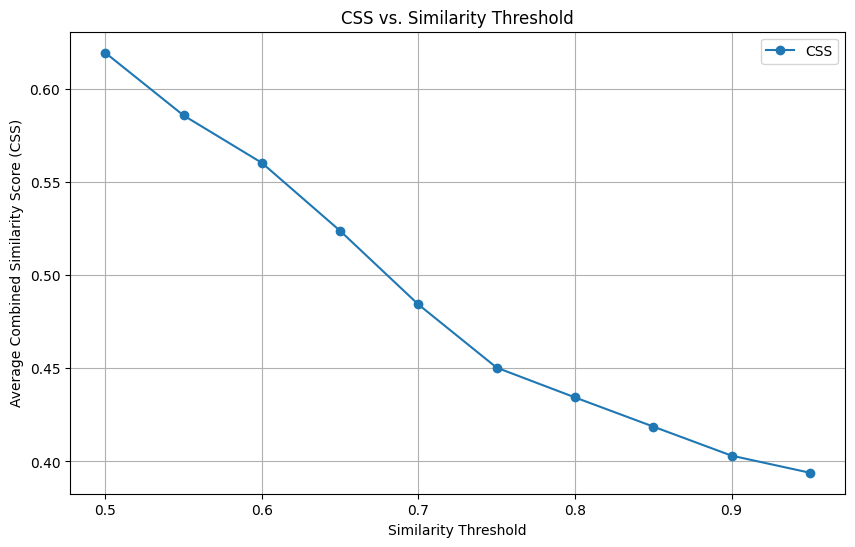

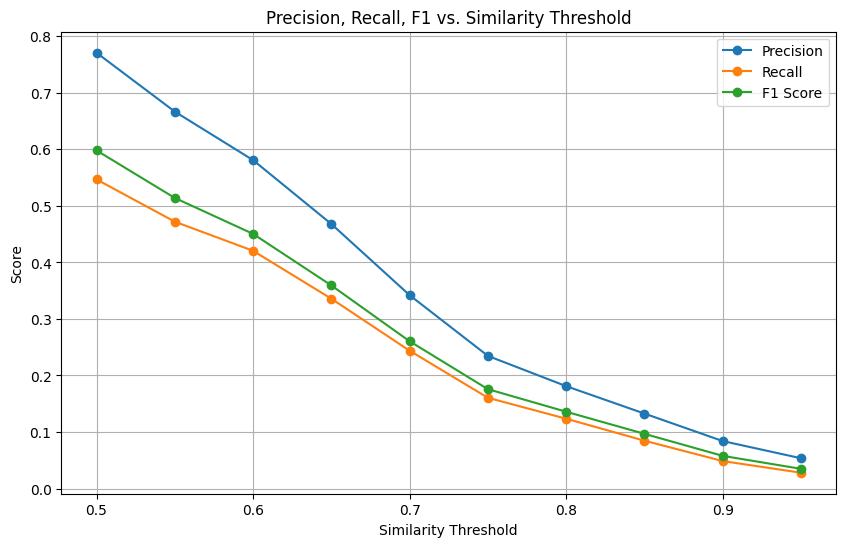

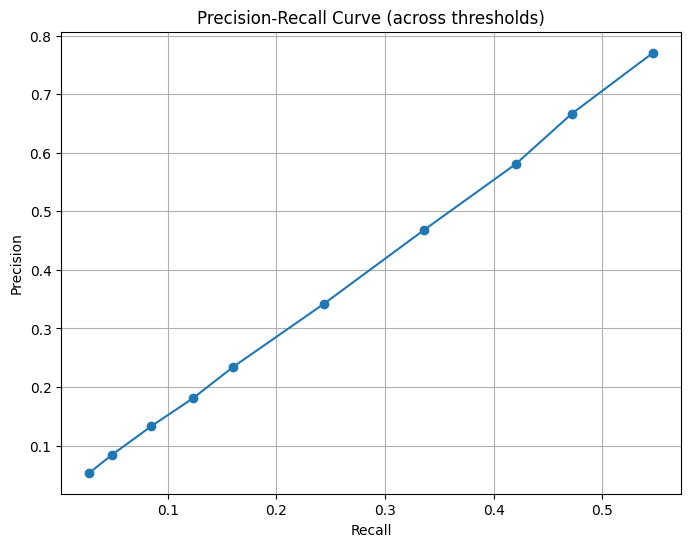

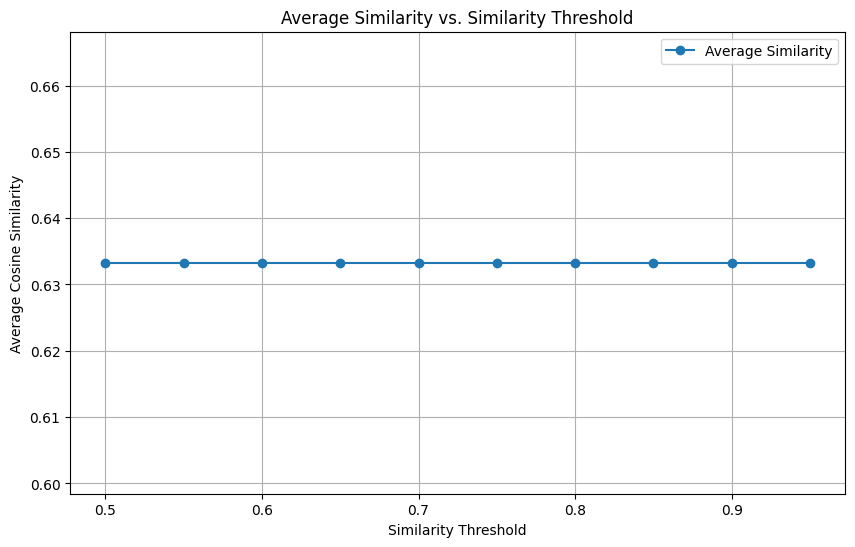

In [5]:
# === Plotting ===
plt.figure(figsize=(10, 6))
plt.plot(results_df['Threshold'], results_df['CSS'], marker='o', label='CSS')
plt.xlabel('Similarity Threshold')
plt.ylabel('Average Combined Similarity Score (CSS)')
plt.title('CSS vs. Similarity Threshold')
plt.grid(True)
plt.legend()
plt.show()

# Precision, Recall, F1 Plot
plt.figure(figsize=(10, 6))
plt.plot(results_df['Threshold'], results_df['Precision'], marker='o', label='Precision')
plt.plot(results_df['Threshold'], results_df['Recall'], marker='o', label='Recall')
plt.plot(results_df['Threshold'], results_df['F1'], marker='o', label='F1 Score')
plt.xlabel('Similarity Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, F1 vs. Similarity Threshold')
plt.grid(True)
plt.legend()
plt.show()

# Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(results_df['Recall'], results_df['Precision'], marker='o')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (across thresholds)')
plt.grid(True)
plt.show()

# Similarity Only
plt.figure(figsize=(10, 6))
plt.plot(results_df['Threshold'], results_df['Avg_Similarity'], marker='o', label='Average Similarity')
plt.xlabel('Similarity Threshold')
plt.ylabel('Average Cosine Similarity')
plt.title('Average Similarity vs. Similarity Threshold')
plt.grid(True)
plt.legend()
plt.show()